In [40]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [41]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\desktop\python\algaenet\dataset\train\images",
    target_size=(75,75),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 700 images belonging to 6 classes.


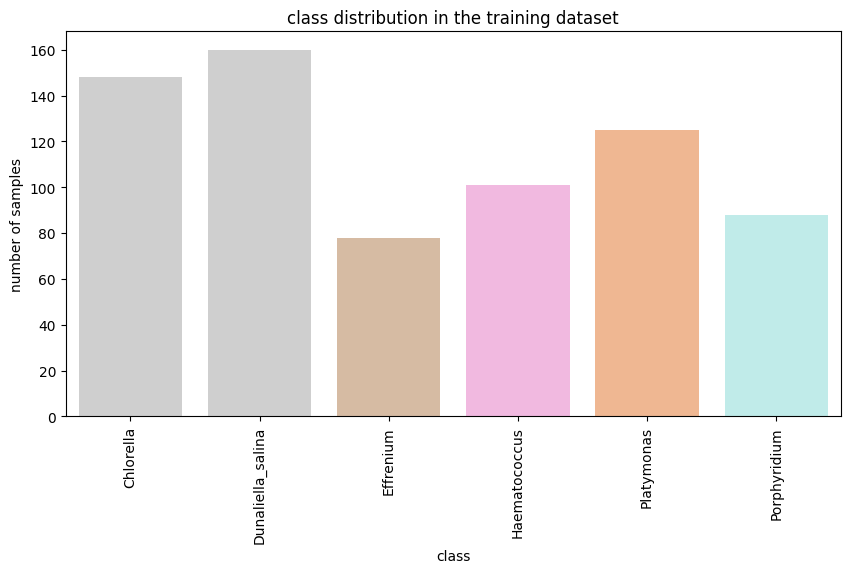

In [42]:
class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

class_distribution = train_generator.classes

class_names_list = [class_names[class_idx] for class_idx in class_distribution]

plt.figure(figsize=(10, 5))
sns.countplot(x=class_names_list, palette='pastel', order=sorted(class_names_list))
plt.title('class distribution in the training dataset')
plt.xlabel('class')
plt.ylabel('number of samples')
plt.xticks(rotation='vertical')
plt.show()

In [43]:
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)

print("class weights")
for class_id, weight in enumerate(class_weights):
    print(f"class- {class_names[class_id]}, weight- {weight}")

class weights
class- Chlorella, weight- 0.7882882882882883
class- Dunaliella_salina, weight- 0.7291666666666666
class- Effrenium, weight- 1.4957264957264957
class- Haematococcus, weight- 1.155115511551155
class- Platymonas, weight- 0.9333333333333333
class- Porphyridium, weight- 1.3257575757575757


In [44]:
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: np.float64(0.7882882882882883),
 1: np.float64(0.7291666666666666),
 2: np.float64(1.4957264957264957),
 3: np.float64(1.155115511551155),
 4: np.float64(0.9333333333333333),
 5: np.float64(1.3257575757575757)}

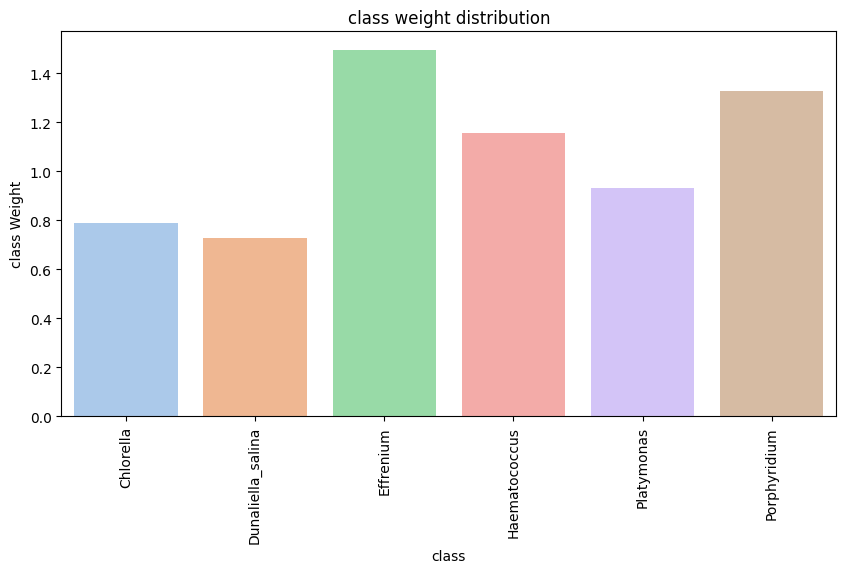

In [45]:
class_weights = [0.78828829, 0.72916667, 1.4957265, 1.15511551, 0.93333333, 1.32575758]
new_class_names = ['Chlorella', 'Dunaliella_salina', 'Effrenium', 'Haematococcus', 'Platymonas', 'Porphyridium']

data = {'Class': new_class_names, 'Weight': class_weights}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Weight', data=df, palette='pastel')
plt.title('class weight distribution')
plt.xlabel('class')
plt.ylabel('class Weight')
plt.xticks(rotation='vertical')
plt.show()

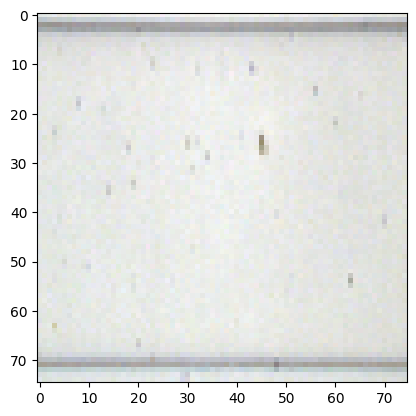

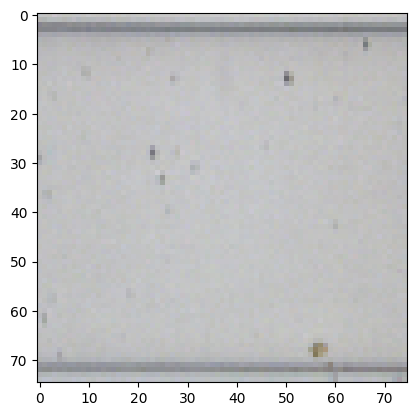

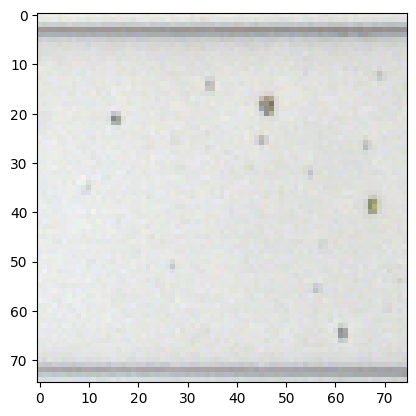

In [46]:
for _ in range(10):
    img, label = next(train_generator)
    if label[0][1] == 1:
        plt.imshow(img[0])
        plt.show()

In [47]:
base_model=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(75,75,3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

In [48]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
InceptionV3_learner=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

In [50]:
InceptionV3_learner.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 1, 1, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,870 (85.18 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [51]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), 
]

In [52]:
InceptionV3_learner.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'] + METRICS,
)

In [53]:
InceptionV3_history=InceptionV3_learner.fit(train_generator,epochs=100,class_weight=class_weight_dict)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.1716 - auc: 0.4956 - loss: 2.0693 - prc: 0.1654 - precision: 0.1863 - recall: 0.0196
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.2485 - auc: 0.5919 - loss: 1.8446 - prc: 0.2207 - precision: 0.2709 - recall: 0.0335
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3142 - auc: 0.6609 - loss: 1.6652 - prc: 0.2913 - precision: 0.5376 - recall: 0.0540
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2882 - auc: 0.6931 - loss: 1.6245 - prc: 0.3067 - precision: 0.5342 - recall: 0.0714
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3190 - auc: 0.7119 - loss: 1.5805 - prc: 0.3417 - precision: 0.5132 - recall: 0.0842
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.3801 - auc: 0.7472 - loss: 1.5080 - prc: 0.3934 - precision: 0.6316 - recall: 0.1065
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.3624 - auc: 0.7609 - loss: 1.4430 

In [54]:
df=pd.DataFrame(InceptionV3_history.history)
df.to_csv("inceptionV3_plot.csv",index=False)

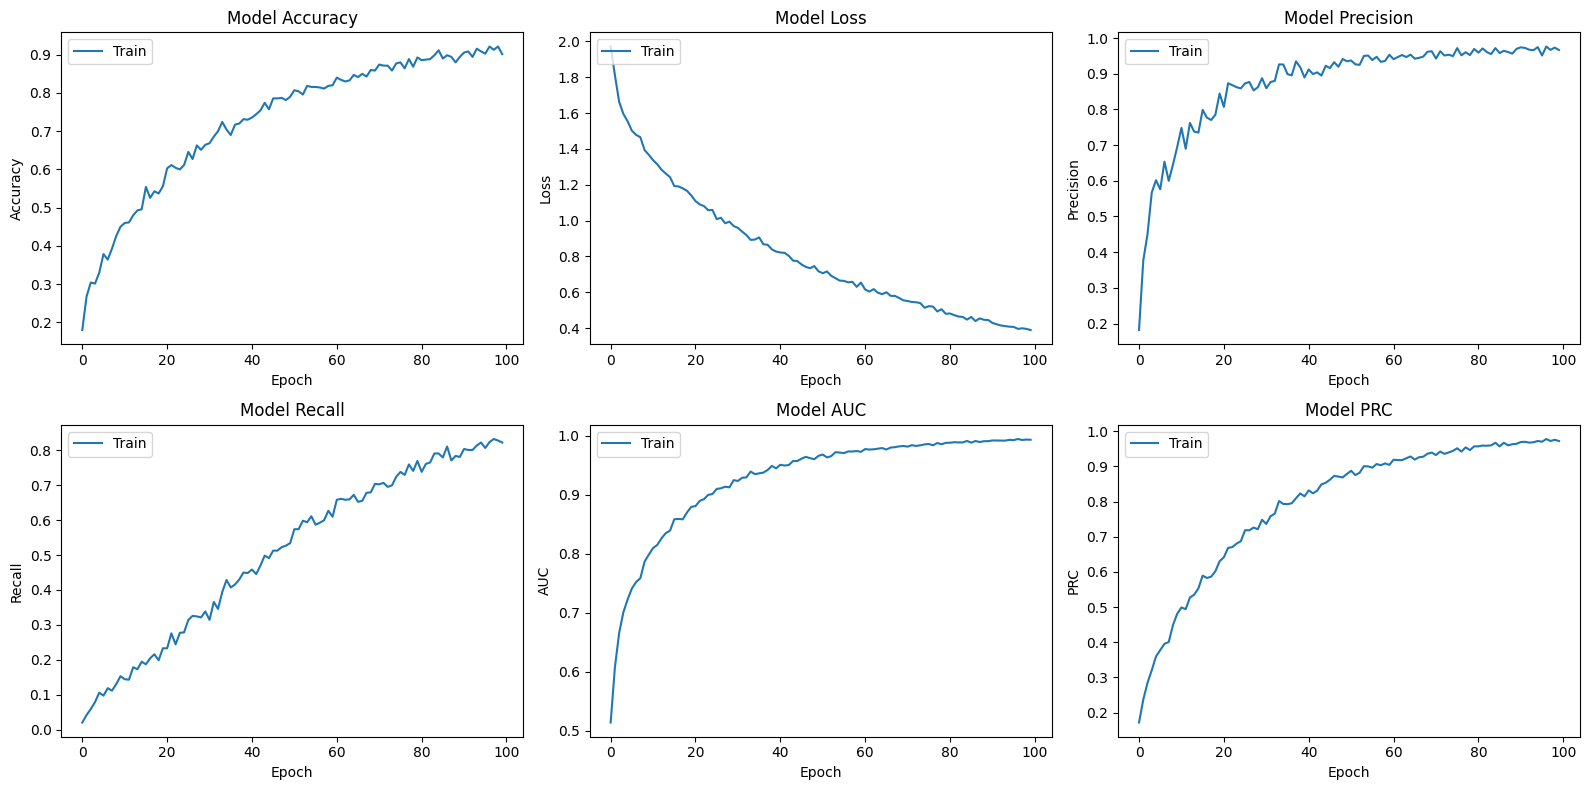

In [55]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.plot(InceptionV3_history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(InceptionV3_history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(InceptionV3_history.history['precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(InceptionV3_history.history['recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(InceptionV3_history.history['auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train'], loc='upper left')

plt.subplot(2, 3, 6)
plt.plot(InceptionV3_history.history['prc'])
plt.title('Model PRC')
plt.xlabel('Epoch')
plt.ylabel('PRC')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()